<center> <h1>PREDICCIÓN DEL SUEÑO</h1> </center>
<center> <h3>CREACIÓN SUBCONJUNTOS DE TRAIN Y TEST</h3> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza</h4> </center>

### Índice de contenidos de este Notebook

En este Notebook se realiza la separación del dataframe en los subgrupos de Train y Test. Como primera aproximación se ha decidido trabajar con un total de 100 ventanas por sujeto y no con todas, por cuestiones de tiempo de ejecución.

    1. Creación de los conjuntos Train y Test
    2. Preparación datos de entrada y salida
    3. Balanceo de los datos

In [31]:
import os
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

Se carga el dataframe creado con las características extraídas de todos los sujetos:

In [32]:
df= pd.read_csv('features.csv')

In [33]:
df.sample(10)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
10186,56.0,57.0,56.67,1.00,-0.10,-0.09,-0.09,0.16,0.17,0.16,-0.98,-0.97,-0.98,1.0,2.0,11.0
9027,51.0,57.0,53.00,1.00,-0.16,-0.15,-0.15,-0.93,-0.92,-0.92,0.32,0.36,0.35,1.0,2.0,10.0
22991,61.0,65.0,63.40,1.00,0.42,0.43,0.42,-0.17,-0.16,-0.16,-0.89,-0.88,-0.89,1.0,2.0,27.0
9078,51.0,52.0,51.67,1.00,0.40,0.41,0.40,0.38,0.40,0.39,-0.84,-0.82,-0.82,1.0,2.0,10.0
965,64.0,66.0,65.33,1.00,0.78,0.79,0.79,-0.04,-0.04,-0.04,-0.62,-0.61,-0.62,1.0,3.0,1.0
21243,65.0,68.0,66.83,1.00,-0.12,-0.11,-0.12,0.78,0.79,0.78,-0.61,-0.60,-0.60,0.0,5.0,25.0
4464,75.0,76.0,75.40,1.00,-0.32,-0.31,-0.32,0.90,0.90,0.90,0.28,0.29,0.29,0.0,5.0,4.0
21527,74.0,74.0,74.00,0.99,-0.00,0.00,-0.00,-0.38,-0.37,-0.37,-0.93,-0.92,-0.92,1.0,2.0,26.0
13766,59.0,61.0,59.67,1.01,0.14,0.15,0.14,0.01,0.01,0.01,0.99,1.00,0.99,1.0,2.0,16.0
18991,52.0,60.0,55.17,1.00,-0.28,-0.26,-0.27,-0.36,-0.35,-0.36,-0.90,-0.89,-0.89,0.0,5.0,23.0


## 1. Creación de los conjuntos Train y Test

Se crean 2 listas aleatorias con una **proporción de 3:1** para Train y Test.

In [34]:
lista = list(range(31)) # Lista de 31 números
suj_train = sample(lista,k=24) # 21 sujetos de train
suj_test = [el for el in lista if el not in suj_train] #Los que no están en train van a test (7)

print(len(suj_train),'sujetos de train:',suj_train)
print(len(suj_test),'sujetos de test:',suj_test)

24 sujetos de train: [24, 4, 12, 26, 14, 15, 0, 1, 2, 11, 7, 17, 8, 21, 22, 13, 29, 27, 23, 5, 18, 16, 10, 3]
7 sujetos de test: [6, 9, 19, 20, 25, 28, 30]


Con cada una de las listas de sujetos anteriores, se crean los conjuntos de Train y Test de manera que no se mezclen los sujetos entre cada uno de los dos subconjuntos:

In [35]:
train_matr = []
test_matr = []
id = df['ID']

for i in suj_train:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    train_matr.append(m)

for i in suj_test:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    test_matr.append(m)

En este caso, los conjuntos de Train y Test se han creado con **100 ventanas** deslizantes y no con todas.

In [42]:
lista_ventanas=list(np.linspace(0,0.99,900))

Train = pd.DataFrame()  
for i in range(len(train_matr)):
    lista_multi=[int(element * len(train_matr[i])) for element in lista_ventanas]
    ven1=train_matr[i].iloc[lista_multi]
    Train=Train.append(ven1)

Test = pd.DataFrame()  
for i in range(len(test_matr)):
    lista_multi=[int(element * len(test_matr[i])) for element in lista_ventanas]
    ven2=test_matr[i].iloc[lista_multi]
    Test=Test.append(ven2)

In [43]:
labels=Train['Etiquetas multiclase']

lab_0 = []
idx_0 = []
list_idx_0 = []

for l in labels:
    if l==0:
        idx_0.append(True)
    else:
        idx_0.append(False)
list_idx_0.append(Train[idx_0])

lab_1 = []
idx_1 = []
list_idx_1 = []

for l in labels:
    if l==1:
        idx_1.append(True)
    else:
        idx_1.append(False)
list_idx_1.append(Train[idx_1])

lab_2 = []
idx_2 = []
list_idx_2 = []

for l in labels:
    if l==2:
        idx_2.append(True)
    else:
        idx_2.append(False)
list_idx_2.append(Train[idx_2])

lab_3 = []
idx_3 = []
list_idx_3 = []

for l in labels:
    if l==3:
        idx_3.append(True)
    else:
        idx_3.append(False)
list_idx_3.append(Train[idx_3])

lab_5 = []
idx_5 = []
list_idx_5 = []

for l in labels:
    if l==5:
        idx_5.append(True)
    else:
        idx_5.append(False)
list_idx_5.append(Train[idx_5])

Train0 = pd.DataFrame()  
for i in range(len(list_idx_0)):
    Train0=Train0.append(list_idx_0[i])
Train1 = pd.DataFrame()  
for i in range(len(list_idx_1)):
    Train1=Train1.append(list_idx_1[i])
Train2 = pd.DataFrame()  
for i in range(len(list_idx_2)):
    Train2=Train2.append(list_idx_2[i])
Train3 = pd.DataFrame()  
for i in range(len(list_idx_3)):
    Train3=Train3.append(list_idx_3[i])
Train5 = pd.DataFrame()  
for i in range(len(list_idx_5)):
    Train5=Train5.append(list_idx_5[i])

In [44]:
labels=Test['Etiquetas multiclase']

lab_0 = []
idx_0 = []
list_idx_0 = []

for l in labels:
    if l==0:
        idx_0.append(True)
    else:
        idx_0.append(False)
list_idx_0.append(Test[idx_0])

lab_1 = []
idx_1 = []
list_idx_1 = []

for l in labels:
    if l==1:
        idx_1.append(True)
    else:
        idx_1.append(False)
list_idx_1.append(Test[idx_1])

lab_2 = []
idx_2 = []
list_idx_2 = []

for l in labels:
    if l==2:
        idx_2.append(True)
    else:
        idx_2.append(False)
list_idx_2.append(Test[idx_2])

lab_3 = []
idx_3 = []
list_idx_3 = []

for l in labels:
    if l==3:
        idx_3.append(True)
    else:
        idx_3.append(False)
list_idx_3.append(Test[idx_3])

lab_5 = []
idx_5 = []
list_idx_5 = []

for l in labels:
    if l==5:
        idx_5.append(True)
    else:
        idx_5.append(False)
list_idx_5.append(Test[idx_5])

Test0 = pd.DataFrame()  
for i in range(len(list_idx_0)):
    Test0=Test0.append(list_idx_0[i])
Test1 = pd.DataFrame()  
for i in range(len(list_idx_1)):
    Test1=Test1.append(list_idx_1[i])
Test2 = pd.DataFrame()  
for i in range(len(list_idx_2)):
    Test2=Test2.append(list_idx_2[i])
Test3 = pd.DataFrame()  
for i in range(len(list_idx_3)):
    Test3=Test3.append(list_idx_3[i])
Test5 = pd.DataFrame()  
for i in range(len(list_idx_5)):
    Test5=Test5.append(list_idx_5[i])

In [45]:
n_lab=min([Train0['Etiquetas multiclase'].value_counts()[0],Train1['Etiquetas multiclase'].value_counts()[1],
      Train2['Etiquetas multiclase'].value_counts()[2],Train3['Etiquetas multiclase'].value_counts()[3],
      Train5['Etiquetas multiclase'].value_counts()[5]])
n_lab

1368

In [46]:
Train_balanced = pd.DataFrame()  
Train_balanced=Train_balanced.append(Train0.sample(n_lab)).append(Train1.sample(n_lab)).append(Train2.sample(n_lab)).append(Train3.sample(n_lab)).append(Train5.sample(n_lab))

In [47]:
# balanceo 75% Train y 25% test
Test=Test.sample(int(len(Train_balanced)*0.25))

### 2.Normalización de los datos

In [48]:
Train_tt=Train.copy()
Test_tt=Test.copy()

In [49]:
Etiquetas = Train[['Etiquetas binarias','Etiquetas multiclase','ID']]

In [50]:
X_train=Train_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
columns_name=list(X_train.columns)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
Train_transformed=pd.DataFrame(X_train_transformed, columns=columns_name)
Train_transformed['Etiquetas multiclase'], Train_transformed['Etiquetas binarias'], Train_transformed['ID'] = [Train['Etiquetas multiclase'].values, Train['Etiquetas binarias'].values, Train['ID'].values]

X_test=Test_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
scaler = preprocessing.StandardScaler().fit(X_train)
X_test_transformed = scaler.transform(X_test)
Test_transformed=pd.DataFrame(X_test_transformed, columns=columns_name)
Test_transformed['Etiquetas multiclase'], Test_transformed['Etiquetas binarias'], Test_transformed['ID'] = [Test['Etiquetas multiclase'].values, Test['Etiquetas binarias'].values, Test['ID'].values]

In [51]:
Train.to_csv('Train.csv', header=True, index=False)
Train_balanced.to_csv('Train_balanced.csv', header=True, index=False)
Test.to_csv('Test.csv', header=True, index=False)
Train_transformed.to_csv('Train_transformed.csv', header=True, index=False)
Test_transformed.to_csv('Test_transformed.csv', header=True, index=False)

In [52]:
Train_balanced.describe()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
count,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000,6840.000000
mean,65.327632,69.701462,67.366480,0.998034,-0.139725,-0.037623,-0.085811,-0.132254,0.022063,-0.053909,-0.529335,-0.392883,-0.467421,0.600000,2.200000,13.923392
std,10.822382,12.331973,11.269444,0.005966,0.388874,0.383129,0.349963,0.519594,0.539824,0.484223,0.636591,0.665247,0.623966,0.489934,1.720591,8.747200
min,41.000000,42.000000,41.170000,0.980000,-3.890000,-0.940000,-0.950000,-2.780000,-1.000000,-1.000000,-3.380000,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,58.000000,61.000000,59.330000,0.990000,-0.410000,-0.320000,-0.350000,-0.490000,-0.350000,-0.380000,-0.930000,-0.890000,-0.900000,0.000000,1.000000,7.000000
50%,64.000000,68.000000,66.290000,1.000000,-0.180000,-0.090000,-0.130000,-0.130000,0.020000,-0.030000,-0.830000,-0.770000,-0.790000,1.000000,2.000000,14.000000
75%,71.000000,77.000000,73.670000,1.000000,0.100000,0.220000,0.150000,0.210000,0.340000,0.260000,-0.260000,0.080000,-0.100000,1.000000,3.000000,22.000000
max,127.000000,130.000000,128.570000,1.060000,0.830000,3.250000,0.850000,0.990000,3.750000,0.990000,0.990000,3.870000,1.000000,1.000000,5.000000,29.000000


### 3. Balanceo de los datos

SUBCONJUNTO DE TRAIN BALANCEADO

In [53]:
print('Número de valores diferentes que hay para etiquetas multiclase:',Train_balanced['Etiquetas multiclase'].nunique(),'\n')

print('Número de veces que se toma cada valor de etiquetas multiclase:')
print(Train_balanced['Etiquetas multiclase'].value_counts(),'\n')

Número de valores diferentes que hay para etiquetas multiclase: 5 

Número de veces que se toma cada valor de etiquetas multiclase:
5.0    1368
3.0    1368
2.0    1368
1.0    1368
0.0    1368
Name: Etiquetas multiclase, dtype: int64 



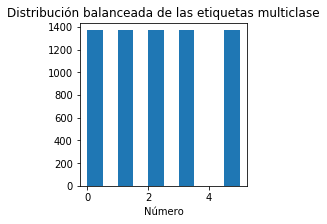

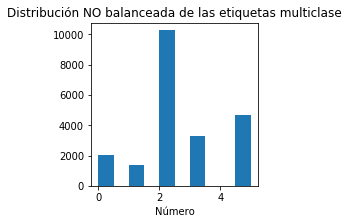

In [54]:
plt.figure(figsize=(3, 3))
plt.title('Distribución balanceada de las etiquetas multiclase')
plt.xlabel("Etiqueta del sueño")
plt.xlabel("Número")
plt.hist(Train_balanced['Etiquetas multiclase'])
plt.show()

plt.figure(figsize=(3, 3))
plt.title('Distribución NO balanceada de las etiquetas multiclase')
plt.xlabel("Etiqueta del sueño")
plt.xlabel("Número")
plt.hist(Train['Etiquetas multiclase'])
plt.show()

1.0    14923
0.0     6677
Name: Etiquetas binarias, dtype: int64
1.0    1185
0.0     525
Name: Etiquetas binarias, dtype: int64


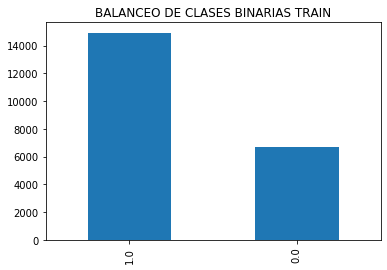

<Figure size 432x288 with 0 Axes>

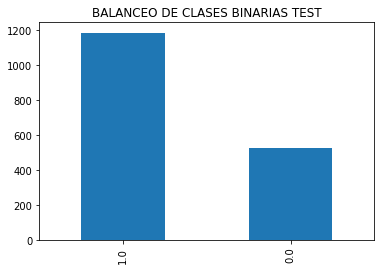

In [55]:
Train['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TRAIN")
plt.figure()
print(Train["Etiquetas binarias"].value_counts() )

#Test['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TEST")
plt.figure()
Test['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TEST")
print(Test["Etiquetas binarias"].value_counts() )

2.0    10261
5.0     4675
3.0     3294
0.0     2002
1.0     1368
Name: Etiquetas multiclase, dtype: int64
2.0    854
5.0    269
0.0    256
3.0    209
1.0    122
Name: Etiquetas multiclase, dtype: int64


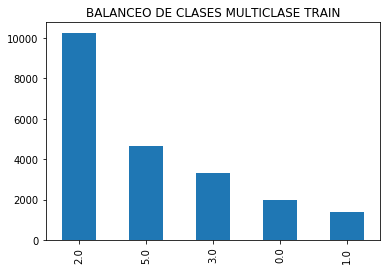

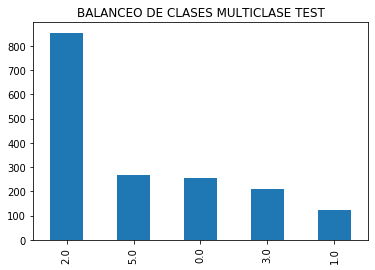

<Figure size 432x288 with 0 Axes>

In [56]:
Train['Etiquetas multiclase'].value_counts().plot.bar(title="BALANCEO DE CLASES MULTICLASE TRAIN")
plt.figure()
print(Train["Etiquetas multiclase"].value_counts() )

Test['Etiquetas multiclase'].value_counts().plot.bar(title="BALANCEO DE CLASES MULTICLASE TEST")
plt.figure()
print(Test["Etiquetas multiclase"].value_counts() )

In [57]:
round(Train_balanced.describe(),2)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
count,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00,6840.00
mean,65.33,69.70,67.37,1.00,-0.14,-0.04,-0.09,-0.13,0.02,-0.05,-0.53,-0.39,-0.47,0.60,2.20,13.92
std,10.82,12.33,11.27,0.01,0.39,0.38,0.35,0.52,0.54,0.48,0.64,0.67,0.62,0.49,1.72,8.75
min,41.00,42.00,41.17,0.98,-3.89,-0.94,-0.95,-2.78,-1.00,-1.00,-3.38,-1.00,-1.00,0.00,0.00,0.00
25%,58.00,61.00,59.33,0.99,-0.41,-0.32,-0.35,-0.49,-0.35,-0.38,-0.93,-0.89,-0.90,0.00,1.00,7.00
50%,64.00,68.00,66.29,1.00,-0.18,-0.09,-0.13,-0.13,0.02,-0.03,-0.83,-0.77,-0.79,1.00,2.00,14.00
75%,71.00,77.00,73.67,1.00,0.10,0.22,0.15,0.21,0.34,0.26,-0.26,0.08,-0.10,1.00,3.00,22.00
max,127.00,130.00,128.57,1.06,0.83,3.25,0.85,0.99,3.75,0.99,0.99,3.87,1.00,1.00,5.00,29.00


In [58]:
round(Test.describe(),2)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
count,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00,1710.00
mean,60.94,64.14,62.45,1.00,-0.26,-0.19,-0.23,-0.19,-0.08,-0.13,-0.45,-0.35,-0.41,0.69,2.22,19.41
std,8.99,10.17,9.39,0.01,0.35,0.36,0.33,0.52,0.53,0.50,0.64,0.65,0.62,0.46,1.47,8.56
min,43.00,45.00,44.17,0.99,-1.80,-0.95,-0.98,-1.56,-0.96,-0.96,-2.20,-0.98,-0.99,0.00,0.00,6.00
25%,54.00,57.00,55.17,0.99,-0.49,-0.43,-0.45,-0.61,-0.53,-0.56,-0.91,-0.86,-0.88,0.00,2.00,9.00
50%,61.00,64.00,62.67,1.00,-0.33,-0.30,-0.32,-0.19,-0.12,-0.15,-0.78,-0.67,-0.75,1.00,2.00,20.00
75%,68.00,72.00,69.80,1.00,-0.08,0.06,-0.02,0.17,0.26,0.21,-0.04,0.20,0.07,1.00,3.00,28.00
max,108.00,112.00,109.40,1.05,0.75,1.70,0.76,0.96,1.37,0.97,1.00,1.61,1.01,1.00,5.00,30.00


In [59]:
int(len(Train_balanced)*0.25)

1710